In [110]:
pip install mlxtend

     |████████████████████████████████| 1.3 MB 3.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [119]:
import numpy as np
import pandas as pd
from qpsolvers import solve_qp
import os
import matplotlib.pyplot as plt
from sklearn import metrics
from mlxtend.evaluate import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [149]:
# Do not change function signatures
#
# input:
#   X is the input matrix of size n_samples x n_features.
#   pass the parameters of the kernel function via kwargs.
# output:
#   Kernel matrix of size n_samples x n_samples 
#   K[i][j] = f(X[i], X[j]) for kernel function f()

def linear(X: np.ndarray, **kwargs)-> np.ndarray:
    m = X.shape[0] #number of samples
    if(m==2):
        return np.dot(X[0], X[1])
    kernel_matrix = X @ X.T 
    return kernel_matrix

def polynomial(X:np.ndarray,**kwargs)-> np.ndarray:
    assert X.ndim == 2
    m = X.shape[0]
    # polynomial transformation given by (eta + gamma (x^T . x'))^Q
    c = np.full((m, m), kwargs['c'])
    gamma = kwargs['gamma']
    q = kwargs['q']
    kernel_matrix =  (c + gamma * (X @ X.T))**q
    return kernel_matrix

def rbf(X:np.ndarray,**kwargs)-> np.ndarray:
    assert X.ndim == 2
    m = X.shape[0]
    gamma = kwargs['gamma']
    kernel_matrix = np.zeros([m,m])
    if(m==2):
        return np.exp((-1)*(gamma)*((np.linalg.norm(X[0]-X[1]))**2))
    for i in range(m):
         for j in range(m):
            kernel_matrix[i][j] = np.exp((-1)*(gamma)*((np.linalg.norm(X[i]-X[j]))**2))
    return kernel_matrix

def sigmoid(X:np.ndarray,**kwargs)-> np.ndarray:
    assert X.ndim == 2
    m = X.shape[0]
    gamma = kwargs['gamma']
    r = kwargs['r']
    kernel_matrix = np.tanh((gamma * (X @ X.T)) + r)
    return kernel_matrix

def laplacian(X:np.ndarray,**kwargs)-> np.ndarray:
    assert X.ndim == 2
    m = X.shape[0]
    kernel_matrix = np.zeros([m,m])
    gamma = kwargs['gamma']
    for i in range(m):
         for j in range(m):
            kernel_matrix[i][j] = np.exp((-1)*(gamma)*(np.linalg.norm(X[i]-X[j],ord=1)))
    return kernel_matrix


In [150]:
from typing import List
import numpy as np
import qpsolvers
class Trainer:
    def __init__(self,kernel,C=None,**kwargs) -> None:
        self.kernel = kernel
        self.kwargs = kwargs
        self.C=C
        self.support_vectors:List[np.ndarray] = []
        
    
    def fit(self, train_data_path:str)->None:
        
        df_train = pd.read_csv(train_data_path)
        df_train.pop(df_train.columns[0])
        X = df_train.loc[: , df_train.columns!='y' ] 
        y = df_train['y']
        y = y.astype(float)
        #To convert 0s to -1
        y = 2*y-1
        
        #no. of samples

        m = X.shape[0]
        X1 = np.array(X)
        K = self.kernel(X1, **self.kwargs)
  


        P = np.outer(y, y) * K
        q = -1 * np.ones(m)
        
        #Hard margin SVM case, hence no upper bounds on alpha
        if self.C is None:
            G = np.eye(m) * -1
            h = np.zeros(m)
        #Soft margin case, alpha has upper bound.
        else:
            G_max = np.eye(m) * -1
            G_min = np.eye(m)
            G = np.vstack((G_max, G_min))
            h_max = np.zeros(m)
            h_min = np.ones(m) * self.C
            h = np.hstack((h_max, h_min))
            
        A = y.values.reshape((1, m))
        b = np.zeros(1)
        alpha = solve_qp(P, q, G, h, A, b, solver="osqp")
   
        idx = np.where(alpha > 0)[0]
        s=idx[0]
        
        df1 = X.iloc[idx]    
        for row in df1.values:
            self.support_vectors.append(row.tolist())
  
        self.support_vector_labels = y[idx]
        self.support_vector_labels = self.support_vector_labels.reset_index(drop=True)
        self.support_vector_alpha = alpha[idx]
    
        sum = 0
        for i in range(m):
            sum = sum + y[i]*alpha[i]*K[i][s]
        
        biasterm = y[s] - sum
        self.bias_term = biasterm
        
    
    def predict(self, test_data_path:str)->np.ndarray:
       
        df_test = pd.read_csv(test_data_path)
        df_test.pop(df_test.columns[0])
        
        X_val = df_test.loc[: , df_test.columns!='y' ]
        y = np.array(df_test['y'])
        m = X_val.shape[0]
        n = len(self.support_vectors)
        X = np.array(X_val)
        y_pred = [0 for i in range(m)] 
    
        for i in range(m):
            for j in range(n):
                y_pred[i] = y_pred[i] + (self.support_vector_labels[j])*(self.support_vector_alpha[j])*(self.kernel(np.array([self.support_vectors[j],X[i]]),**self.kwargs))
            
            
        y_pred_final = [0]*m
        for i in range(m):
            y_pred_final[i] = (np.sign(y_pred[i] + self.bias_term)+1)/2
              
        return y_pred_final
        


In [39]:
dff = pd.read_csv("/Users/valayaramchandani/Downloads/bi_val.csv")
y = np.array(dff['y'])

In [40]:
linear_svm = Trainer(linear, 1)
linear_svm.fit("/Users/valayaramchandani/Downloads/bi_train.csv")

/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


In [41]:
Accuracy = metrics.accuracy_score(y_pred_final, y)
Accuracy

0.717948717948718

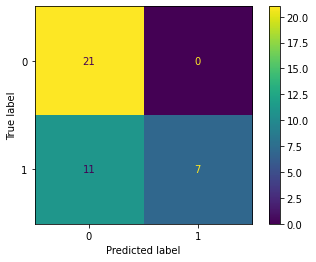

In [42]:
confusion_matrix = metrics.confusion_matrix(y, y_pred_final)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

In [214]:
dff = pd.read_csv("/Users/valayaramchandani/Downloads/bi_val.csv")
y = np.array(dff['y'])

In [269]:
linear_svm = Trainer(rbf, 0.2, gamma=0.0002)
linear_svm.fit("/Users/valayaramchandani/Downloads/bi_train.csv")

/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


In [270]:
y_pred_final = linear_svm.predict("/Users/valayaramchandani/Downloads/bi_val.csv")

In [271]:
Accuracy = metrics.accuracy_score(y_pred_final, y)
Accuracy

0.9487179487179487

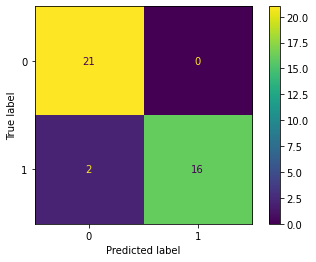

In [272]:
confusion_matrix = metrics.confusion_matrix(y, y_pred_final)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot()
plt.show()

# Multiclass - 0V0

In [151]:
from typing import List
import numpy as np
from svm_binary import Trainer

class Trainer_OVO:
    def __init__(self, kernel, C=None, n_classes=-1, **kwargs) -> None:
        self.kernel = kernel
        self.C = C
        self.n_classes = n_classes
        self.kwargs = kwargs
        self.svms = [] # List of Trainer objects [Trainer]

    def _init_trainers(self):
        # Initiate the svm trainers for all pairs of classes
        n = self.n_classes
        for i in range(n):
            for j in range(i+1, n):
                svm = Trainer(kernel=self.kernel, C=self.C, **self.kwargs)
                self.svms.append((i,j,svm))

    def fit(self, train_data_path:str, max_iter=None)->None:
        
        df_train = pd.read_csv(train_data_path)
        df_train.pop(df_train.columns[0])
        y = np.array(df_train['y'])
        self.classes = np.unique(y)
        self.n_classes = len(np.unique(y))
        self._init_trainers()

        for i, j, svm in self.svms:
            df_ij = df_train.loc[(df_train['y'] == self.classes[i]) | (df_train['y'] == self.classes[j])]
            df_ij['y'] = df_ij['y'].replace(self.classes[i], 1)
            df_ij['y'] = df_ij['y'].replace(self.classes[j], 0)
            df_ij.to_csv("mydata.csv") 
            svm.fit("mydata.csv")
            os.remove("mydata.csv")
            
    def predict(self, test_data_path:str)->np.ndarray:
        # Load test data
        df_test = pd.read_csv(test_data_path)
        y_val = df_test['y']
        n_samples = len(df_test.index)
        y_pred = np.zeros((n_samples, self.n_classes))
        for i, j, svm in self.svms:
            # Predict the labels for the test data
#             df_ij_val = df_test.loc[(df_test['y'] == i) | (df_test['y'] == j)]
            y_pair_pred = svm.predict(test_data_path)
            for g in range(len(y_pair_pred)):
                if(y_pair_pred[g]==1):
                    y_pair_pred[g]= self.classes[i]
                if(y_pair_pred[g]==0):
                    y_pair_pred[g]= self.classes[j]
            
            #print(y_pair_pred)
            # Accumulate the predictions
            for k in range(n_samples):
                y_pred[k, int(y_pair_pred[k])-1] += 1
                
            # Determine the class with the most votes for each sample

        return np.argmax(y_pred, axis=1)+1


In [425]:
dff = pd.read_csv("/Users/valayaramchandani/Downloads/multi_val.csv")
y = np.array(dff['y'])

In [434]:
linear_svm = Trainer_OVO(rbf, 1.2, gamma=0.1)
linear_svm.fit("/Users/valayaramchandani/Downloads/multi_train.csv")

/var/folders/8v/4n20m59n1z7g8vbcnjym5g_r0000gn/T/ipykernel_1133/229555024.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ij['y'] = df_ij['y'].replace(self.classes[i], 1)
/var/folders/8v/4n20m59n1z7g8vbcnjym5g_r0000gn/T/ipykernel_1133/229555024.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ij['y'] = df_ij['y'].replace(self.classes[j], 0)
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.s

In [435]:
y_guess = linear_svm.predict("/Users/valayaramchandani/Downloads/multi_val.csv")

In [436]:
y

array([9., 4., 3., 5., 4., 3., 9., 4., 7., 6., 3., 4., 8., 7., 5., 7., 8.,
       5., 9., 6., 2., 7., 6., 1., 5., 1., 3., 6., 6., 4., 2., 6., 6., 3.,
       3., 4., 3., 7., 7.])

In [437]:
len(y)

39

In [438]:
y_guess

array([7, 4, 3, 5, 4, 3, 8, 4, 7, 6, 3, 4, 7, 8, 5, 7, 7, 5, 9, 6, 2, 7,
       5, 1, 5, 1, 3, 6, 6, 4, 2, 6, 6, 3, 4, 4, 4, 6, 7])

In [439]:
len(y_guess)

39

In [440]:
Accuracy = metrics.accuracy_score(y_guess, y)
Accuracy

0.7692307692307693

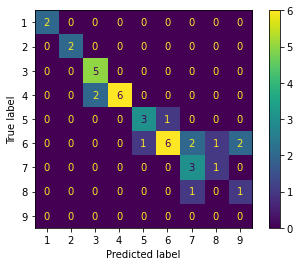

In [433]:
confusion_matrix = metrics.confusion_matrix(y_guess, y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4,5,6,7,8,9])
cm_display.plot()
plt.show()

TypeError: plot_confusion_matrix() got an unexpected keyword argument 'conf_mat'

In [423]:
linear_svmOVO = Trainer_OVO(rbf, C=0.1, gamma=0.1) 
linear_svmOVO.fit("/Users/valayaramchandani/Downloads/multi_train.csv")

/var/folders/8v/4n20m59n1z7g8vbcnjym5g_r0000gn/T/ipykernel_1133/229555024.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ij['y'] = df_ij['y'].replace(self.classes[i], 1)
/var/folders/8v/4n20m59n1z7g8vbcnjym5g_r0000gn/T/ipykernel_1133/229555024.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ij['y'] = df_ij['y'].replace(self.classes[j], 0)
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.s

In [424]:
y_pred = linear_svm.predict("/Users/valayaramchandani/Downloads/multi_val.csv")

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0.

In [130]:
y_pred

array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [891]:
y_val=y_val.astype(float)

In [892]:
y_val - y_pred

array([ 0.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0.,  1.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,
        0., -1.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,  0.])

# Multiclass OVA


In [401]:
class Trainer_OVA:
    def __init__(self, kernel, C=None, n_classes=-1, **kwargs)->None:
        self.kernel = kernel
        self.C = C
        self.n_classes = n_classes
        self.kwargs = kwargs
        self.svms = [] # List of Trainer objects [Trainer]
    
    def _init_trainers(self):
        for i in range(self.n_classes):
            svm_i = Trainer(kernel=self.kernel, C=self.C, **self.kwargs)
            self.svms.append(svm_i)
    
    def fit(self, train_data_path:str, max_iter=None)->None:
        
        df_train = pd.read_csv(train_data_path)
        df_train.pop(df_train.columns[0])
        y = np.array(df_train['y'])
        self.classes = np.unique(y)
        self.n_classes = len(np.unique(y))
        self._init_trainers()

        for i in range(self.n_classes):           
            svm_i = self.svms[i]
            y_new = np.ones(len(y))
            for l in range(len(y)):
                if(y[l]!=i):
                    y_new[l]=0
            df_train['y']=y_new
            df_train.to_csv("mydata.csv") 
            svm_i.fit("mydata.csv")
            os.remove("mydata.csv")
    
    def predict(self, test_data_path:str)->np.ndarray:
        df_test = pd.read_csv(test_data_path)
        n = len(df_test.index)
        y = np.array(df_test['y'])
        
        y_pred = np.zeros((n, self.n_classes))
        
        for i in range(self.n_classes):
            svm_i = self.svms[i]
            
            y_pred[:, i] = svm_i.predict(test_data_path)
               
        return np.argmax(y_pred, axis=1)+1

In [415]:
linear_svm = Trainer_OVA(rbf, 0.1,gamma=0.1) 
linear_svm.fit("/Users/valayaramchandani/Downloads/multi_train.csv")

/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted G to scipy.sparse.csc.csc_matrix
For best performance, build G as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/Users/valayaramchandani/opt/anaconda3/lib/python3.9/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.s

In [416]:
y_pred = linear_svm.predict("/Users/valayaramchandani/Downloads/multi_val.csv")

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0.

In [417]:
y_pred

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [418]:
dff = pd.read_csv("/Users/valayaramchandani/Downloads/multi_val.csv")
y = np.array(dff['y'])

In [419]:
y

array([9., 4., 3., 5., 4., 3., 9., 4., 7., 6., 3., 4., 8., 7., 5., 7., 8.,
       5., 9., 6., 2., 7., 6., 1., 5., 1., 3., 6., 6., 4., 2., 6., 6., 3.,
       3., 4., 3., 7., 7.])

In [420]:
Accuracy = metrics.accuracy_score(y_pred, y)
Accuracy

0.07692307692307693

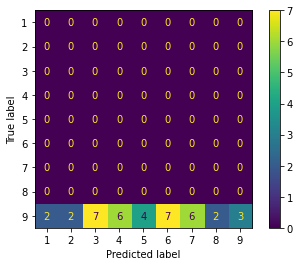

In [421]:
confusion_matrix = metrics.confusion_matrix(y_pred, y)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3, 4,5,6,7,8,9])
cm_display.plot()
plt.show()

# BEST

In [441]:
from typing import Union
from svm_binary import Trainer as T
from svm_multiclass import Trainer_OVO as T_ovo, Trainer_OVA as T_ova

def best_classifier_two_class()->T:
    """Return the best classifier for the two-class classification problem."""
    #TODO: implement, use best performing values for C, kernel functions and all the parameters of the kernel functions
    # Set Hyper-params
    trainer = T(rbf, 0.2, gamma=0.0002)
    return trainer

def best_classifier_multi_class()->Union[T_ovo,T_ova]:
    """Return the best classifier for the multi-class classification problem."""
    #TODO: implement, use best performing model with optimum values for C, kernel functions and all the parameters of the kernel functions.
    # Set Hyper-params
    # Set the trainer to either of T_ovo or T_ova
    # Create trainer with hyper-parameters
    trainer = T_OVO(rbf, 1.2, gamma=0.1)
    return trainer

ModuleNotFoundError: No module named 'svm_binary'